In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 26.4 MB/s 
     |████████████████████████████████| 163 kB 68.8 MB/s 
     |████████████████████████████████| 7.6 MB 59.6 MB/s 


In [ ]:
img_dir = "https://vizwiz.cs.colorado.edu//VizWiz_visualization_img/"

In [ ]:
import requests

In [ ]:
##3. Training data
split = "train"
annotation_file_train = "https://vizwiz.cs.colorado.edu/VizWiz_final/vqa_data/Annotations/%s.json" %split
split_data = requests.get(annotation_file_train, allow_redirects=True)
train_data = split_data.json()
print(len(train_data))

20523


In [ ]:
## validation dataset

split = "val"
annotation_file_val = "https://vizwiz.cs.colorado.edu/VizWiz_final/vqa_data/Annotations/%s.json" %split
split_data_val = requests.get(annotation_file_val, allow_redirects=True)
val_data = split_data_val.json()
print(len(val_data))

4319


In [ ]:
# test dataset

split = "test"
annotation_file_test = "https://vizwiz.cs.colorado.edu/VizWiz_final/vqa_data/Annotations/%s.json" %split
split_data = requests.get(annotation_file_test, allow_redirects=True)
test_data = split_data.json()
print(len(test_data))

8000


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
from keras.applications.vgg16 import VGG16
image_model = VGG16(weights='imagenet', include_top=False) 

def clean_answers_data(answers,common_answers):
  result = [] 
  answers_len = len(answers) 
  for i in range(answers_len):    
    if answers[i] in common_answers:
      result.append(answers[i])
    else:
      result.append(common_answers[0]) #print(result) 
  return result

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
from skimage import io
import numpy as np
from keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from urllib import request
from io import BytesIO
from PIL import Image


def extract_image_features(image_url):
  res = request.urlopen(image_url).read()
  img = Image.open(BytesIO(res)).resize((128,128))
  img_data = img_to_array(img)
  img_data = np.expand_dims(img_data, axis = 0)
  img_data = preprocess_input(img_data)
  features = image_model.predict(img_data)
  arr = np.array(features)
  image_feature_vector = arr.ravel()
  #print(image_feature_vector)
  #print(len(image_feature_vector))
  return image_feature_vector

In [ ]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") 

def tokenize_function(examples):
  return tokenizer(examples, padding="max_length", truncation=True) 

def extract_question_features(question):
  tokenized_question = tokenize_function(question) 
  return tokenized_question['input_ids']

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
from collections import Counter
answer_list = [] 
X = [] ## features 
y = [] ## target labels 
for vq in train_data[17000:19000]:
  # Extract features describing the image
  image_name = vq['image']
  image_url = img_dir + image_name 
  image_feature = extract_image_features(image_url)
  question = vq['question']
  question_feature = extract_question_features(question)

  # Create a multimodal feature to represent both the image and question (e.g. concate 
  multimodal_features = np.concatenate((question_feature, image_feature))

  # Prepare features and labels 
  X.append(multimodal_features)

  answers = vq['answers']

  label = answers[0]['answer']

  answer_list.append(label)

multimodal_features_len = len(X)

clean_answer_list = answer_list

frequent_answers_counter = Counter(answer_list).most_common(10) 
frequent_answers = [x[0] for x in frequent_answers_counter] 
class_labels_len = len(le.fit_transform(answer_list)) 
print(frequent_answers)

1/1 [==============================] - 0s 16ms/step
['unanswerable', 'unsuitable', 'no', 'yes', 'grey', 'white', 'black', 'blue', 'pink', 'green']


In [ ]:
import tensorflow as tf

Y = tf.stack(le.transform(clean_answer_list)) 
#print(clean_answer_list) 
X = tf.stack(X) 
#print(X)
X_B = X
Y_B = Y
#print(X_B)

In [ ]:
import matplotlib.pyplot as plt
def plot_graph(graph_val):
  plt.plot(graph_val.history["accuracy"], color ="blue", label = "train-accuracy")
  plt.plot(graph_val.history["val_accuracy"], color ="red", label = "val-accuracy")
  plt.title("Plot for validation accuracy") 
  plt.ylabel("Accuracy") 
  plt.xlabel("Number of epochs") 
  plt.legend() 
  plt.show()

In [ ]:
from keras.models import Sequential 
from keras.layers import Embedding, Dense, LSTM 

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


50/50 [==============================] - 1s 17ms/step - loss: 7.5048 - accuracy: 0.1050 - val_loss: 7.2611 - val_accuracy: 0.1600
Epoch 2/30
50/50 [==============================] - 0s 9ms/step - loss: 4.5131 - accuracy: 0.1725 - val_loss: 7.9232 - val_accuracy: 0.1375
Epoch 3/30
50/50 [==============================] - 0s 9ms/step - loss: 3.5550 - accuracy: 0.1950 - val_loss: 8.1534 - val_accuracy: 0.1175
Epoch 4/30
50/50 [==============================] - 0s 9ms/step - loss: 2.9016 - accuracy: 0.3069 - val_loss: 8.4053 - val_accuracy: 0.1200
Epoch 5/30
50/50 [==============================] - 0s 9ms/step - loss: 2.3156 - accuracy: 0.4456 - val_loss: 8.5994 - val_accuracy: 0.1300
Epoch 6/30
50/50 [==============================] - 0s 8ms/step - loss: 1.7929 - accuracy: 0.5962 - val_loss: 8.7926 - val_accuracy: 0.1150
Epoch 7/30
50/50 [==============================] - 0s 8ms/step - loss: 1.5001 - accuracy: 0.6669 - val_loss: 8.8515 - val_accuracy: 0.1300
Epoch 8/30
50/50 [============

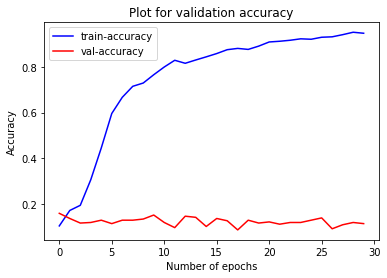

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2000)              17410000  
                                                                 
 dense_1 (Dense)             (None, 2000)              4002000   
                                                                 
Total params: 21,412,000
Trainable params: 21,412,000
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(multimodal_features_len, activation='sigmoid'), 
  tf.keras.layers.Dense(class_labels_len, activation='sigmoid')
  ]) 
model_1.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
graph_val = model_1.fit(X, Y, epochs=30,  validation_split= 0.2)
plot_graph(graph_val) 
model_1.summary()

Epoch 1/30
50/50 [==============================] - 1s 18ms/step - loss: 6.8215 - accuracy: 0.1169 - val_loss: 6.2993 - val_accuracy: 0.1550
Epoch 2/30
50/50 [==============================] - 1s 14ms/step - loss: 5.7186 - accuracy: 0.1331 - val_loss: 6.7915 - val_accuracy: 0.1450
Epoch 3/30
50/50 [==============================] - 1s 14ms/step - loss: 5.3910 - accuracy: 0.1375 - val_loss: 6.8589 - val_accuracy: 0.1650
Epoch 4/30
50/50 [==============================] - 1s 14ms/step - loss: 5.0413 - accuracy: 0.1481 - val_loss: 7.8989 - val_accuracy: 0.1550
Epoch 5/30
50/50 [==============================] - 1s 14ms/step - loss: 4.6528 - accuracy: 0.1544 - val_loss: 7.5733 - val_accuracy: 0.1650
Epoch 6/30
50/50 [==============================] - 1s 14ms/step - loss: 4.2950 - accuracy: 0.1581 - val_loss: 8.3336 - val_accuracy: 0.1625
Epoch 7/30
50/50 [==============================] - 1s 14ms/step - loss: 3.9885 - accuracy: 0.1675 - val_loss: 7.8434 - val_accuracy: 0.1325
Epoch 8/30
50

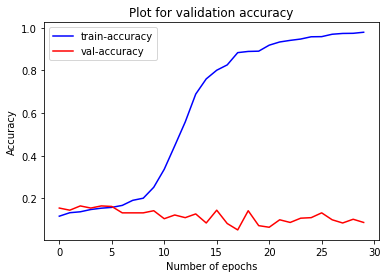

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2000)              17410000  
                                                                 
 dense_3 (Dense)             (None, 2000)              4002000   
                                                                 
 dense_4 (Dense)             (None, 2000)              4002000   
                                                                 
Total params: 25,414,000
Trainable params: 25,414,000
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2 = tf.keras.Sequential([ 
    tf.keras.layers.Dense(multimodal_features_len, activation='sigmoid'),
  tf.keras.layers.Dense(multimodal_features_len, activation='sigmoid'), 
  tf.keras.layers.Dense(class_labels_len, activation='sigmoid')
]) 
model_2.compile(optimizer='RMSProp', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
graph_val = model_2.fit(X, Y, epochs=30,  validation_split= 0.2)
plot_graph(graph_val) 
model_2.summary()

Epoch 1/30
50/50 [==============================] - 1s 13ms/step - loss: 72.1317 - accuracy: 0.0500 - val_loss: 21.3095 - val_accuracy: 0.0525
Epoch 2/30
50/50 [==============================] - 0s 9ms/step - loss: 10.1189 - accuracy: 0.1500 - val_loss: 18.4770 - val_accuracy: 0.0600
Epoch 3/30
50/50 [==============================] - 0s 9ms/step - loss: 6.0607 - accuracy: 0.2619 - val_loss: 16.9629 - val_accuracy: 0.1000
Epoch 4/30
50/50 [==============================] - 1s 10ms/step - loss: 4.1835 - accuracy: 0.3950 - val_loss: 15.9254 - val_accuracy: 0.1075
Epoch 5/30
50/50 [==============================] - 1s 11ms/step - loss: 3.1805 - accuracy: 0.5075 - val_loss: 16.0599 - val_accuracy: 0.0950
Epoch 6/30
50/50 [==============================] - 1s 11ms/step - loss: 2.3570 - accuracy: 0.6344 - val_loss: 16.4242 - val_accuracy: 0.0950
Epoch 7/30
50/50 [==============================] - 1s 10ms/step - loss: 1.9729 - accuracy: 0.7088 - val_loss: 16.3775 - val_accuracy: 0.0900
Epoch 

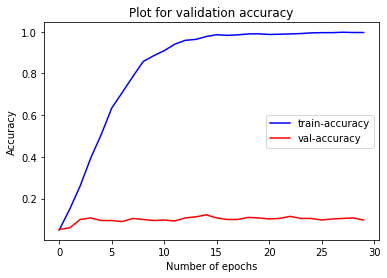

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 2000)              17410000  
                                                                 
 dense_6 (Dense)             (None, 2000)              4002000   
                                                                 
 dense_7 (Dense)             (None, 2000)              4002000   
                                                                 
 dense_8 (Dense)             (None, 2000)              4002000   
                                                                 
Total params: 29,416,000
Trainable params: 29,416,000
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(multimodal_features_len, activation='relu'), 
  tf.keras.layers.Dense(multimodal_features_len, activation='relu'), 
  tf.keras.layers.Dense(multimodal_features_len, activation='relu'), 
  tf.keras.layers.Dense(class_labels_len, activation='sigmoid')

]) 
model_3.compile(optimizer='Adagrad', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
graph_val = model_3.fit(X, Y, epochs=30, validation_split= 0.2)
plot_graph(graph_val) 
model_3.summary()

In [ ]:
from sklearn.metrics import average_precision_score
def validate(results,data):
  # All answers 
  gtlist = [x['answerable'] for x in data] 
  # Save the accuracies 
  y_test = []
  pred_list = []
  i=0
  #print(results)

  # Compute accuracy for each image 
  for i in range(0, 600):
    # Get the GT answer list and preprocess
    y_test.append(gtlist[i])
    if results[i] >0.5:
      pred_list.append(1)
    else:
      pred_list.append(0)
  y_test = np.array(y_test)
  pred = np.array(pred_list)
  average_precision = average_precision_score(y_test, pred)
  print("AP: {}".format(round(100*average_precision, 4)))

In [ ]:
X = [] ## features 
y = [] ## target labels 
multimodal_features_set = []

for vq in val_data[1000:1600]:
  # Extract features describing the image
  image_name = vq['image']

  image_url = img_dir + image_name 
  image_feature = extract_image_features(image_url)
  #print(image_feature) # Extract features describing the question
  question = vq['question']

  question_feature = extract_question_features(question) 
  #print(question_feature) 
  # Create a multimodal feature to represent both the image and question (e.g. concate 
  multimodal_features = np.concatenate((question_feature, image_feature)) 
  multimodal_features_set.append(multimodal_features)

1/1 [==============================] - 0s 15ms/step


In [ ]:
multimodal_features_tensor = tf.convert_to_tensor(multimodal_features_set) 
predicted_values_1 = model_1.predict(multimodal_features_tensor) 
results_1 = [np.amax(predicted_values_1[i]) for i in range(len(predicted_values_1))]
validate(results_1,val_data[1000:1600])


19/19 [==============================] - 0s 2ms/step
AP: 68.0


In [ ]:
count0 = 0
count1=0
for val in results_1:
  if val > 0.5:
    count1+=1
  else:
    count0+=1
print(count0)
print(count1)

600
0


In [ ]:
multimodal_features_tensor = tf.convert_to_tensor(multimodal_features_set) 
predicted_values_2 = model_2.predict(multimodal_features_tensor) 
results_2 = [np.amax(predicted_values_2[i]) for i in range(len(predicted_values_2))]
validate(results_2,val_data[1000:1600])

19/19 [==============================] - 0s 3ms/step
AP: 68.0


In [ ]:
multimodal_features_tensor = tf.convert_to_tensor(multimodal_features_set) 
predicted_values_3 = model_3.predict(multimodal_features_tensor) 
results_3 = [np.amax(predicted_values_3[i]) for i in range(len(predicted_values_3))]
validate(results_3,val_data[1000:1600])

19/19 [==============================] - 0s 3ms/step
AP: 68.0


In [ ]:
def plot_graph(graph_val):
  plt.plot(graph_val.history["loss"], color ="blue", label = "train-loss")
  plt.plot(graph_val.history["val_loss"], color ="red", label = "val-accuracy")
  plt.title("Plot for loss") 
  plt.ylabel("Accuracy") 
  plt.xlabel("Number of epochs") 
  plt.legend() 
  plt.show()

In [ ]:
num_VQs = 1000 
results = [] 
multimodal_features_set = [] ##X = [] ## features y = [] ## target labels 

for vq in test_data[0:num_VQs]:
  # Extract features describing the image
  image_name = vq['image']
  image_url = img_dir + image_name 
  image_feature = extract_image_features(image_url)
  question = vq['question']
  question_feature = extract_question_features(question) 
  multimodal_features = np.concatenate((question_feature, image_feature)) 
  multimodal_features_set.append(multimodal_features)

multimodal_features_tensor = tf.convert_to_tensor(multimodal_features_set) 
predicted_values_final = model_3.predict(multimodal_features_tensor)
#index_of_maximums = [np.where(output == max(output)) for output in predicted_values]
#result = [x[0].tolist()[0] for x in index_of_maximums]
#results = le.inverse_transform(result) 
results = [np.amax(predicted_values_final[i]) for i in range(len(predicted_values_final))]
#print(results)

32/32 [==============================] - 0s 3ms/step


In [ ]:
print(results)

[0.99983966, 0.9999857, 1.0, 0.9996476, 0.9993789, 0.9998447, 0.9990036, 0.99987614, 0.99855906, 1.0, 0.9999317, 0.99971265, 0.99828523, 0.9998945, 1.0, 0.9999795, 0.99997723, 1.0, 1.0, 1.0, 0.9997881, 0.99977344, 1.0, 0.9999747, 0.9999809, 1.0, 0.9999919, 0.9998036, 1.0, 1.0, 1.0, 1.0, 0.99937063, 0.9999995, 1.0, 0.9996402, 1.0, 0.9996953, 0.99999416, 1.0, 0.9996325, 1.0, 0.9998851, 0.9988439, 1.0, 1.0, 0.9999993, 1.0, 0.99999774, 0.9996711, 0.99999714, 0.9997009, 0.99999344, 0.99948716, 1.0, 0.9999155, 0.9999994, 0.9999994, 0.9999583, 0.9999999, 1.0, 0.99990666, 1.0, 0.9999231, 0.99997187, 1.0, 0.99985707, 1.0, 0.99999785, 0.9996562, 0.99998724, 1.0, 0.9999907, 1.0, 0.99995804, 0.9999815, 0.99999905, 1.0, 0.9999577, 0.99952984, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998802, 0.9999815, 1.0, 1.0, 0.99999976, 0.99999976, 0.9999896, 0.99996984, 0.9997774, 1.0, 1.0, 0.9994259, 0.9999758, 0.9989511, 0.9999927, 0.9997476, 0.99999285, 1.0, 0.9999901, 0.9997992, 0.9998348, 0.9999989, 1.0, 0.99915564, 0.

In [ ]:
import pandas as pd 
df = pd.DataFrame(results) 
df.to_csv("results.csv", header = None, index = None)